Take a look at:

* https://github.com/lzane/Fingers-Detection-using-OpenCV-and-Python
* https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
* https://github.com/tensorboy/pytorch_Realtime_Multi-Person_Pose_Estimation
* 
* 
* 
* 
* 


me: 131_

In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from skimage import io, transform

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%matplotlib inline

import timeit, random
import json, cv2
import show

%load_ext autoreload
%autoreload 2

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
def rel_error(x, y):
  """ returns relative error """ 
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [3]:
# Dataset class for memory efficient data processing 
class HandGestureDataset(torch.utils.data.Dataset):
    """ Hand Gesture Dataset """

    def __init__(self, root_dir, transform=False):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.joints = json.load(open(self.root_dir+"annotation.json","r"))
        self.names = self.joints.keys()
#         self.images =  ## Can't load all 12G worth of images
        self.transform = transform

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        idx = np.random.randint(0, len(self.names))
        name = self.names[idx]
        
        image = cv2.imread("Dataset/Images/" + self.names[idx][:-2] + ".jpg")
        temp = []
        for i in xrange(len(self.joints[name])):
            temp.append([int(self.joints[name][i][0]), int(self.joints[name][i][1])])
            
        sample = {'image': image, 
                  'joints': temp,
                  'name' : name
                 }

        if self.transform:
            sample = self.hog(sample)

        return sample
    
    def substract_mean(self, sample):
        sample['image'] = sample['image'].astype(np.float64) - np.mean(sample['image']).astype(np.float64)
        return sample
    
    def hog(self, sample):
#         sample['image'] = cv2.Laplacian(sample['image'], cv2.CV_64F)
#         sample['image'] = cv2.Sobel(sample['image'], cv2.CV_64F, 1, 0, ksize=5)
        sample['image'] = cv2.Sobel(sample['image'], cv2.CV_64F, 0, 1, ksize=5)
        return sample
        

In [7]:
class ToTensor(object):
    """
    Convert ndarrays in sample to Tensors.
    * From PyTorch tutorial * 
    """

    def __call__(self, sample):
        image, joints = sample['image'], sample['joints']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'joints': torch.from_numpy(joints)}

In [4]:
# DataLoader class to create a muli-process iterator and load data into memory faster
data = HandGestureDataset("Dataset/", transform=False)
dataloader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True, num_workers=4)

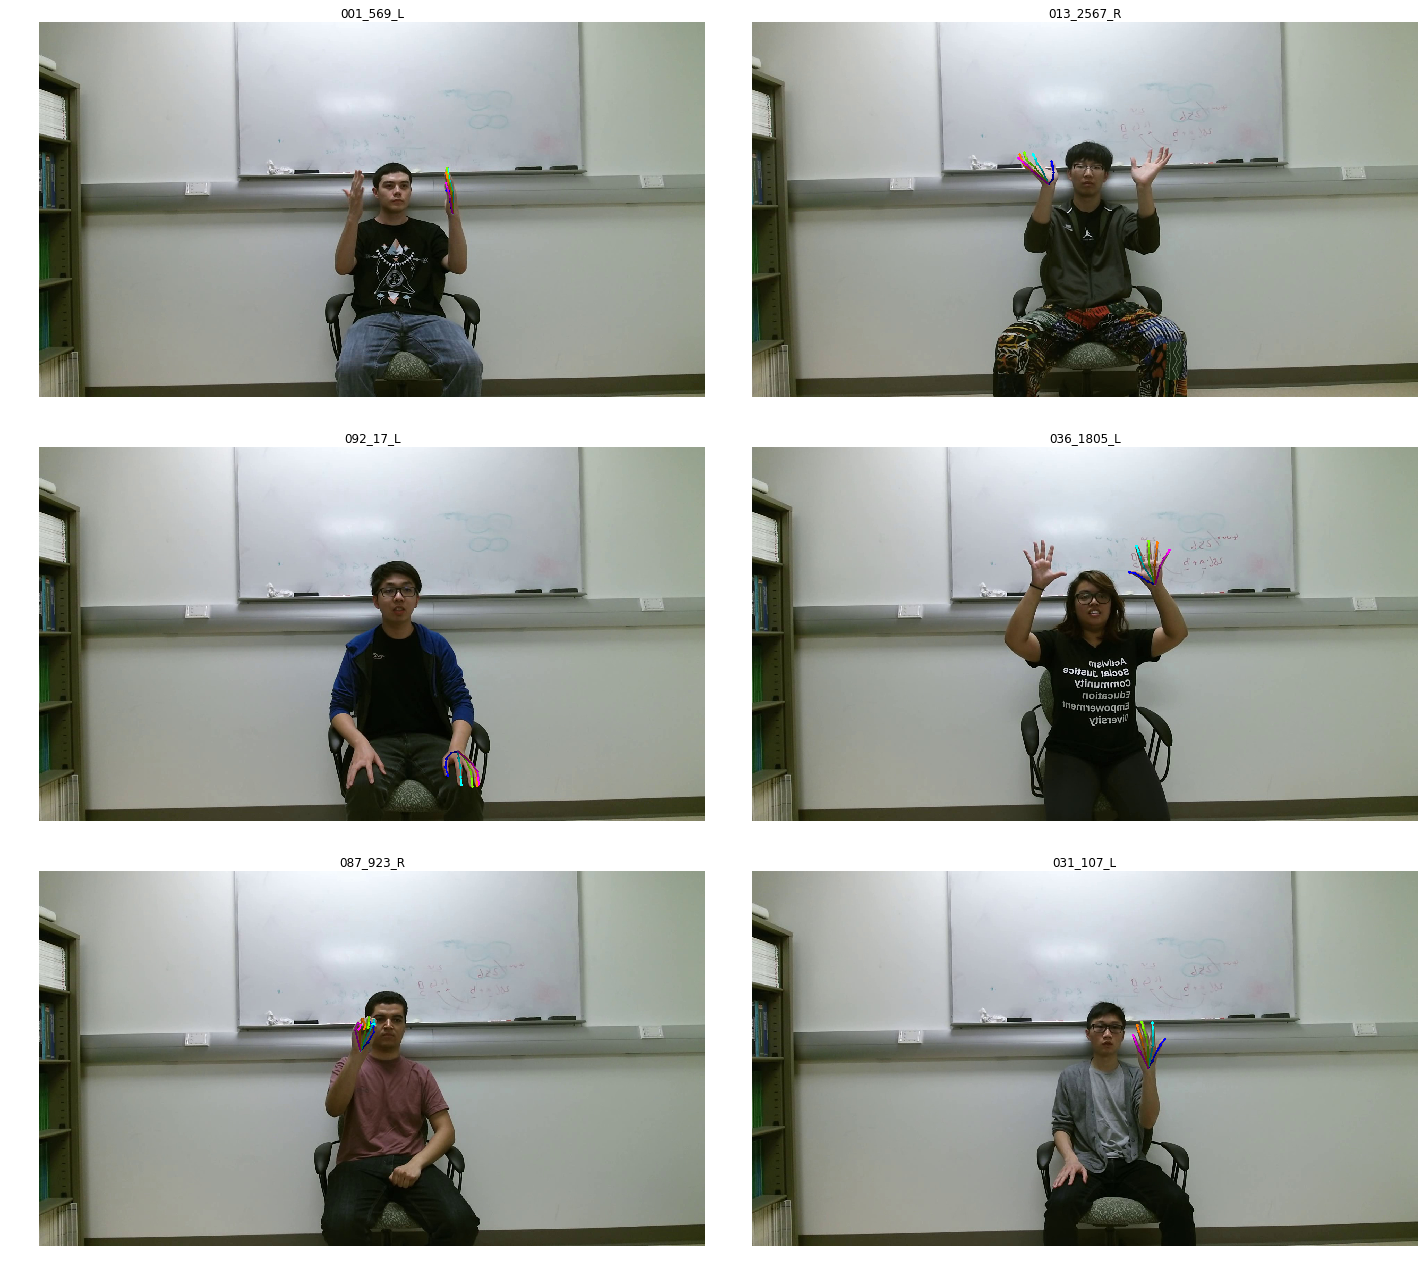

In [5]:
num = 6
fix, ax = plt.subplots(num//2, 2, figsize=(20, num*3))
ax = [a for b in ax for a in b] # wooooo


for i in range(len(data)):
    sample = data[i]
    
    plt.tight_layout()
    ax[i].set_title(sample['name'])
    ax[i].axis('off')
    
    canvas = show.draw_hand(sample['image'], sample['joints'])
    ax[i].imshow(canvas[:,:,::-1])

    if i == num-1:
        plt.show()
        break

In [8]:
torch.cuda.is_available()

False

In [ ]:
class Net(nn.Module):
    def __init__(self):
        